In this notebook, we make a few plots of detected ligand receptor genes in EOMESpos/HOPXpos AOIs:

In [1]:
import sys,os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)

In [2]:
%pylab inline
import pandas as pd
import NaiveDE
import SpatialDE
import statsmodels.stats.multitest as multi
import scipy.stats as ss
import scipy as sp
import pickle as pickle
import scipy as sc
import matplotlib
import matplotlib.colors as colors
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


Load the data and remove negative probes for this analysis:

In [3]:
adata = pickle.load(open('../KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p',  "rb"))
adata = adata[:,adata.var_names != 'NegProbe-WTX']
adata.layers['Stabilized'] = NaiveDE.stabilize(adata.X)
adata.obs['TotalCounts'] = np.sum(adata.X, axis = 1)
adata.layers['TotalCountsRegressed'] = NaiveDE.regress_out(adata.obs, adata.layers['Stabilized'].T, 'np.log(TotalCounts)').T

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [4]:
adata.obs['GeoLOD2.0_01'] = adata.obs['NegGeoMean_01'] * adata.obs['NegGeoSD_01']**2

Define the genes we are interested in:

In [5]:
receptors = np.array(('LIFR', 'IL6ST', 'PTPRZ1', 'ITGB5', 'HS6ST1', 'SDC3', 'FGFR1', 'FGFR2','FGFR3', 'ERBB4'))
ligands = np.array(('LIF', 'TNC', 'PTN', 'FGF1', 'FGF2', 'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FGF7', 'FGF8', 'FGF9', 'FGF10', 'HBEGF'))
receptors_index = [np.where(adata.var_names == receptors[i])[0][0] for i in range(len(receptors))]
ligands_index = [np.where(adata.var_names == ligands[i])[0][0] for i in range(len(ligands))]

Choose HOPXpos AOIs:

In [6]:
colourCode = pickle.load(open('../KR_NAS/0_publication_figures_scripts/celltypesColourCode.p',  "rb"))
roiRelations = pickle.load(open('../KR_NAS/data/ROI_relations.p', 'rb'))
roiRelations

,Slide,Radial_position,VCDepth,Background,HOPXpos,EOMESpos,ParallelROI,Ring
0,00MU,1,0.028892,126,111,103,107,118
1,00MU,1,0.094703,156,141,134,122,148
2,00MU,1,0.205457,96,172,164,137,180
3,00MU,1,0.303371,127,112,104,152,119
4,00MU,1,0.382022,157,142,135,160,149
5,00MU,3,0.028892,94,170,162,107,178
6,00MU,3,0.094703,125,110,102,122,117
7,00MU,3,0.205457,155,140,133,137,147
8,00MU,3,0.303371,95,171,163,152,179
9,00MU,3,0.382022,97,173,165,160,181


Show their expression in a dot plot over cortical depth, with colour indicating enrichment to background:

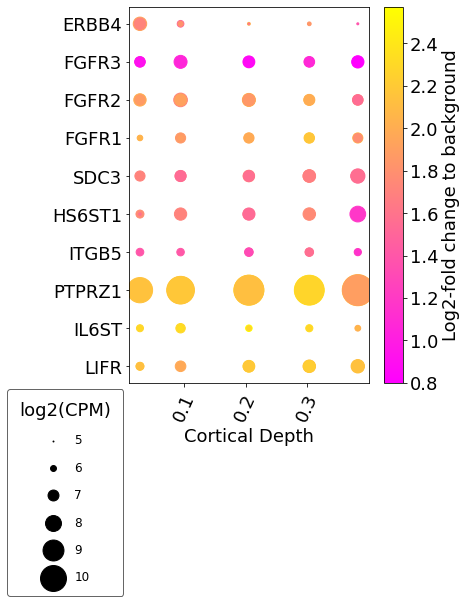

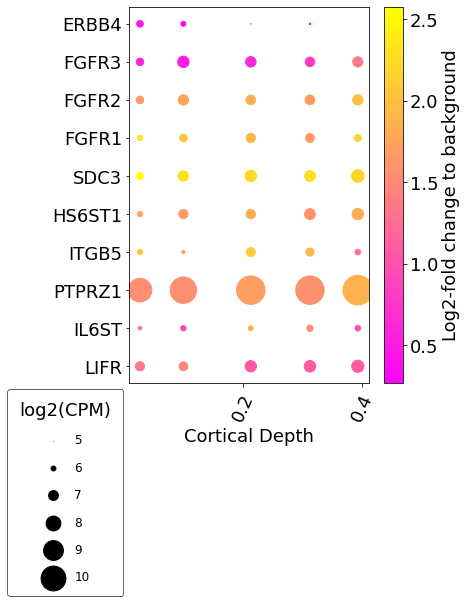

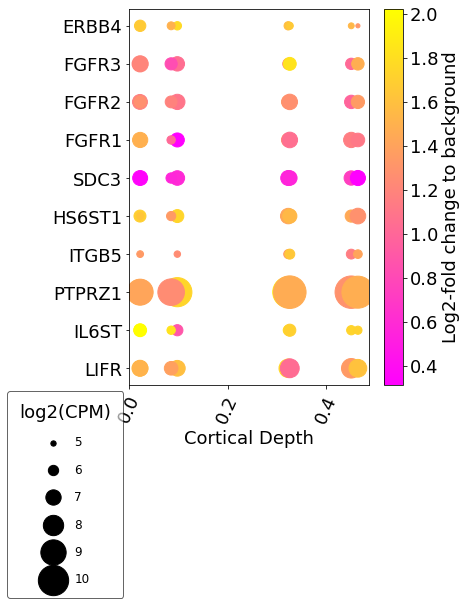

In [7]:
import matplotlib.colors as colors

slides = np.array(('00MU', '00MV', '00MW'))

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 5
power = 2

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):

    roi_dimension = np.array(adata.obs['roi_dimension'].iloc[:,0])
    vc_depth = np.array(adata.obs['VCDepth'])
    
    eomes_index = list(roiRelations['EOMESpos'].loc[roiRelations['Slide'] == slides[i]])
    hopx_index = list(roiRelations['HOPXpos'].loc[roiRelations['Slide'] == slides[i]])
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    residual_index = list(roiRelations['Background'].loc[roiRelations['Slide'] == slides[i]])
    ring_index = list(roiRelations['Ring'].loc[roiRelations['Slide'] == slides[i]])
    
    countsForPlot1 = np.array([np.log2(adata.layers['X'][hopx_index, i]/np.sum(adata.layers['X'], axis = 1)[hopx_index]*10**(6))
                      for i in receptors_index])
    countsForPlot2 = np.array([(np.log2(adata.layers['X'][eomes_index, i] + adata.layers['X'][residual_index, i])/
                       (np.sum(adata.layers['X'], axis = 1)[eomes_index] + 
                       np.sum(adata.layers['X'], axis = 1)[residual_index])*10**(6))
                      for i in receptors_index])
    
    enrichmentForPlot = np.array([np.log2(countsForPlot1[i, :]) -
                                  np.log2(countsForPlot2[i, :])
                                  for i in range(len(receptors_index))]).T

    celltypesForPlot = np.repeat(receptors,len(hopx_index))
    vcForPlot = np.array([vc_depth[hopx_index]
                          for j in range(len(receptors))]).flatten()
    
    fig = plt.figure(figsize = (6.75,9))
    
    mesh = plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot1*scaling) + countsForPlot1*scaling))**power),
                c= enrichmentForPlot, edgecolors='face', cmap = 'spring')
    cbar = fig.colorbar(mesh)
    cbar.set_label('Log2-fold change to background')
    plt.xlabel('Cortical Depth')
    plt.title('HOPXpos AOIs')
    
    # make a legend:
    pws = [0,5,6,7,8,9,10]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot1*scaling) + pw*scaling))**power, c="black",label=str(pw))
    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="log2(CPM)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(0, 0))
    
    plt.tight_layout()
    plt.xticks(rotation=66)
    plt.title('')
    
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_oRG-Interactions_ReceptorsInHOPXpos' + labels[i] +'.pdf',
                bbox_inches='tight')
    plt.show()

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log2


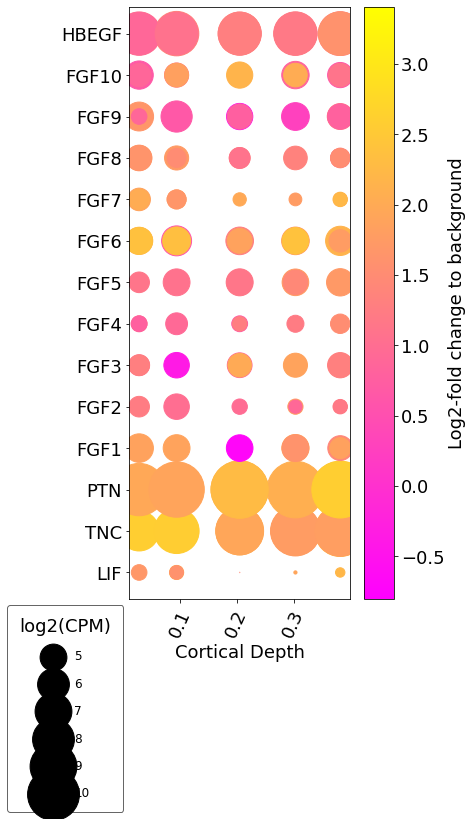

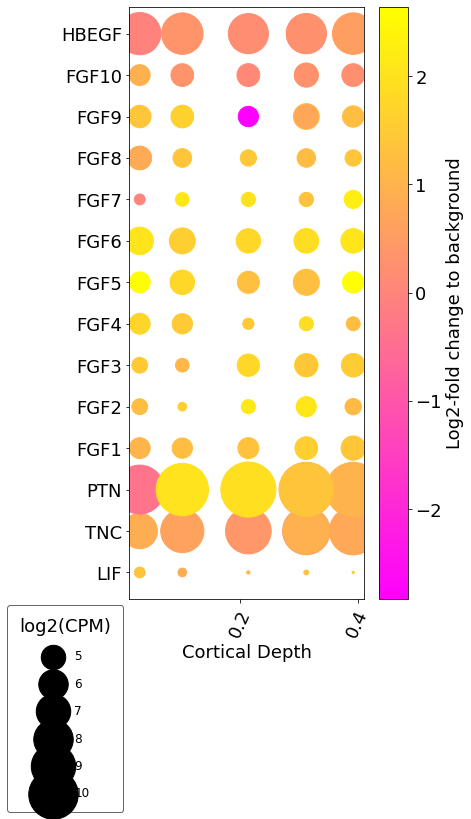

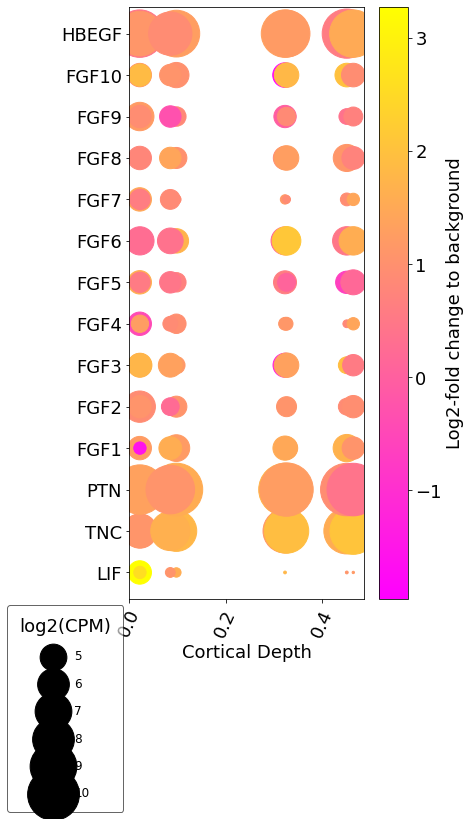

In [8]:
import matplotlib.colors as colors

slides = np.array(('00MU', '00MV', '00MW'))

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scaling = 5
power = 2

labels = ('19pcw_1', '19pcw_2', '14pcw_1')

for i in range(len(slides)):

    roi_dimension = np.array(adata.obs['roi_dimension'].iloc[:,0])
    vc_depth = np.array(adata.obs['VCDepth'])
    
    eomes_index = list(roiRelations['EOMESpos'].loc[roiRelations['Slide'] == slides[i]])
    hopx_index = list(roiRelations['HOPXpos'].loc[roiRelations['Slide'] == slides[i]])
    geometric_index = list(roiRelations['ParallelROI'].loc[roiRelations['Slide'] == slides[i]])
    residual_index = list(roiRelations['Background'].loc[roiRelations['Slide'] == slides[i]])
    ring_index = list(roiRelations['Ring'].loc[roiRelations['Slide'] == slides[i]])
    
    countsForPlot1 = np.array([np.log2(adata.layers['X'][hopx_index, i]/np.sum(adata.layers['X'], axis = 1)[hopx_index]*10**(6))
                      for i in ligands_index])
    countsForPlot2 = np.array([(np.log2(adata.layers['X'][eomes_index, i] + adata.layers['X'][residual_index, i])/
                       (np.sum(adata.layers['X'], axis = 1)[eomes_index] + 
                       np.sum(adata.layers['X'], axis = 1)[residual_index])*10**(6))
                      for i in ligands_index])
    
    enrichmentForPlot = np.array([np.log2(countsForPlot1[i, :]) -
                                  np.log2(countsForPlot2[i, :])
                                  for i in range(len(ligands_index))]).T

    celltypesForPlot = np.repeat(ligands,len(hopx_index))
    vcForPlot = np.array([vc_depth[hopx_index]
                          for j in range(len(ligands))]).flatten()
    
    fig = plt.figure(figsize = (6.75,12))
    
    mesh = plt.scatter(vcForPlot, celltypesForPlot, s=np.float64(((-np.amin(countsForPlot1*scaling) + countsForPlot1*scaling))**power),
                c= enrichmentForPlot, edgecolors='face', cmap = 'spring')
    cbar = fig.colorbar(mesh)
    cbar.set_label('Log2-fold change to background')
    plt.xlabel('Cortical Depth')
    plt.title('HOPXpos AOIs')
    
    # make a legend:
    pws = [0,5,6,7,8,9,10]
    for pw in pws:
        plt.scatter([], [], s=((-np.amin(countsForPlot1*scaling) + pw*scaling))**power, c="black",label=str(pw))
    h, l = plt.gca().get_legend_handles_labels()
    lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="log2(CPM)", borderpad=1, 
                frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(0, 0))
    
    plt.tight_layout()
    plt.xticks(rotation=66)
    plt.title('')
    
    #plt.subplots_adjust(left = 0.25)
    plt.savefig('0_publication_figures/Figure4_oRG-Interactions_LigandsInHOPXpos' + labels[i] +'.pdf',
                bbox_inches='tight')
    plt.show()

Now instead choose all cellphoneDB interactions that are highly specific for oRGs:

Make a table that contains all genes that make up a complex:

In [9]:
gene_table = pd.read_csv('../data/CellPhoneDB/gene_input.csv')
complex_table = pd.read_csv('../data/CellPhoneDB/complex_input.csv')
complex_table = complex_table.iloc[:,0:5]
complex_table['uniprot_1'] = [np.array(gene_table['gene_name'].loc[gene_table['uniprot'] == u])[0] if u in np.array(gene_table['uniprot']) else None for u in complex_table['uniprot_1']]
complex_table['uniprot_2'] = [np.array(gene_table['gene_name'].loc[gene_table['uniprot'] == u])[0] if u in np.array(gene_table['uniprot']) else None for u in complex_table['uniprot_2']]
complex_table['uniprot_3'] = [np.array(gene_table['gene_name'].loc[gene_table['uniprot'] == u])[0] if u in np.array(gene_table['uniprot']) else None for u in complex_table['uniprot_3']]
complex_table['uniprot_4'] = [np.array(gene_table['gene_name'].loc[gene_table['uniprot'] == u])[0] if u in np.array(gene_table['uniprot']) else None for u in complex_table['uniprot_4']]
complex_table.columns = ('complex_name', 'gene_name_1', 'gene_name_2', 'gene_name_3', 'gene_name_4')
complex_table.to_csv('../data/CellPhoneDB/complex_to_genes.csv')

And put this information into the interaction table:

In [10]:
interaction_table = pd.read_table('../data/fetalBrain/Polioudakis/cellPhoneDB/significant_means.txt')
interaction_table['gene_a'] = [a if isinstance(a, str) 
 else list(filter(None,complex_table.loc[:, ('gene_name_1', 'gene_name_2', 'gene_name_3', 'gene_name_4')].iloc[np.where(complex_table['complex_name'] == interaction_table['partner_a'].iloc[i].split(':')[1])[0][0]])) 
 for i,a in enumerate(np.array(interaction_table['gene_a']))]
interaction_table['gene_b'] = [a if isinstance(a, str) 
 else list(filter(None,complex_table.loc[:, ('gene_name_1', 'gene_name_2', 'gene_name_3', 'gene_name_4')].iloc[np.where(complex_table['complex_name'] == interaction_table['partner_b'].iloc[i].split(':')[1])[0][0]])) 
 for i,a in enumerate(np.array(interaction_table['gene_b']))]

Check which genes (including all genes of a complex) are in the WTA panel and only keep those:

In [11]:
subset_a = [np.sum([g not in adata.var_names for g in interaction_table['gene_a'].iloc[i]]) == 0
 if isinstance(interaction_table['gene_a'].iloc[i], list)
 else interaction_table['gene_a'].iloc[i] in adata.var_names
 for i in range(len(interaction_table['gene_a']))]
subset_b = [np.sum([g not in adata.var_names for g in interaction_table['gene_b'].iloc[i]]) == 0
 if isinstance(interaction_table['gene_b'].iloc[i], list)
 else interaction_table['gene_b'].iloc[i] in adata.var_names
 for i in range(len(interaction_table['gene_b']))]
subset = [subset_a[i] and subset_b[i] for i in range(len(subset_a))]
interaction_table_removed = interaction_table.iloc[~np.array(subset),:]
interaction_table = interaction_table.iloc[np.array(subset),:]

Now let's summarize all oRG specific interactions:

In [12]:
oRG_position = [np.where('oRG' == np.array(y))[0] for y in [x.split('|') for x in interaction_table.keys()] if 'oRG' in y]
subset = ~np.isnan(interaction_table.iloc[:,['oRG' in y for y in [x.split('|') for x in interaction_table.keys()]]])
oRG_position_unique = [np.unique([item for sublist in [oRG_position[x] for x in np.where(subset.iloc[i,:])[0]] for item in sublist]) for i in range(len(subset.iloc[:,0])) if sum(subset.iloc[i,:]) > 0]
subset = np.sum(subset, axis = 1) != 0
interact_genes = pd.DataFrame(np.concatenate([interaction_table.loc[:,('id_cp_interaction', 'gene_a', 'gene_b', 'receptor_a', 'receptor_b')].loc[subset],
                                 np.array(oRG_position_unique).reshape(118,1)], axis = 1), columns = ('id_cp_interaction', 'gene_a', 'gene_b', 'receptor_a', 'receptor_b', 'oRG_position'))
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0]
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1]
2,CPI-SS0DA366C78,EPHB2,EFNB3,True,True,[0]
3,CPI-SS06A0B20BD,FGFR2,EPHA4,True,True,[0]
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1]
...,...,...,...,...,...,...
113,CPI-SS04F3A1E5C,COPA,SORT1,False,True,"[0, 1]"
114,CPI-SS02D18D12B,CADM3,CADM4,False,False,[1]
115,CPI-SS0889E281D,CADM1,CADM1,False,False,"[0, 1]"
116,CPI-SS027E12A36,MDK,PTPRZ1,False,False,"[0, 1]"


and also output those that were removed not found in WTA gene names:

In [13]:
oRG_position = [np.where('oRG' == np.array(y))[0] for y in [x.split('|') for x in interaction_table_removed.keys()] if 'oRG' in y]
subset = ~np.isnan(interaction_table_removed.iloc[:,['oRG' in y for y in [x.split('|') for x in interaction_table_removed.keys()]]])
oRG_position_unique = [np.unique([item for sublist in [oRG_position[x] for x in np.where(subset.iloc[i,:])[0]] for item in sublist]) for i in range(len(subset.iloc[:,0])) if sum(subset.iloc[i,:]) > 0]
subset = np.sum(subset, axis = 1) != 0
interact_genes2 = pd.DataFrame(np.concatenate([interaction_table_removed.loc[:,('gene_a', 'gene_b', 'receptor_a', 'receptor_b')].loc[subset],
                                 np.array(oRG_position_unique).reshape(6,1)], axis = 1), columns = ('gene_a', 'gene_b', 'receptor_a', 'receptor_b', 'oRG_position'))
interact_genes2['missing_gene'] = [[x for x in np.append(interact_genes2['gene_a'].iloc[i], interact_genes2['gene_b'].iloc[i]) if x not in adata.var_names][0]
for i in range(np.shape(interact_genes2)[0])]
interact_genes2

,gene_a,gene_b,receptor_a,receptor_b,oRG_position,missing_gene
0,COL6A1,"[ITGB1, ITGA2]",False,False,1,COL6A1
1,COL18A1,"[ITGB1, ITGA2]",False,False,1,COL18A1
2,CXCL12,CXCR4,False,True,1,CXCR4
3,COL4A1,"[ITGB1, ITGA2]",False,False,1,COL4A1
4,PGRMC2,CCL4L2,True,False,0,CCL4L2
5,CXADR,FAM3C,True,False,1,CXADR


In [14]:
# Save missing interaction table:
interact_genes2.to_csv('../KR_NAS/0_publication_tables/oRGSpecific_ReceptorLigands_MissingInPanel.csv')

Finally, check how many interactions are detected in HOPXpos AOIs, EOMESpos AOIs and residual AOIs at 19pcw respectively respectively, requiring at lest two detections above LoD2.0:

In [15]:
slides = ('00MU', '00MV')
eomes_index = list(roiRelations['EOMESpos'].loc[[x in slides for x in roiRelations['Slide']]])
hopx_index = list(roiRelations['HOPXpos'].loc[[x in slides for x in roiRelations['Slide']]])
geometric_index = list(roiRelations['ParallelROI'].loc[[x in slides for x in roiRelations['Slide']]])
residual_index = list(roiRelations['Background'].loc[[x in slides for x in roiRelations['Slide']]])
ring_index = list(roiRelations['Ring'].loc[[x in slides for x in roiRelations['Slide']]])

interaction_detected = list()
for i in range(np.shape(interact_genes)[0]):
    oRG_gene = [interact_genes['gene_a'].iloc[i], interact_genes['gene_b'].iloc[i]][interact_genes['oRG_position'].iloc[i][0]]
    other_gene = [interact_genes['gene_a'].iloc[i], interact_genes['gene_b'].iloc[i]][(1,0)[interact_genes['oRG_position'].iloc[i][0]]]
    if isinstance(oRG_gene, list):
        oRG_gene_index = [np.where(adata.var_names == g)[0][0] for g in oRG_gene]
        oRG_gene_detection = np.all([np.sum(adata.X[hopx_index, j] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2 for j in oRG_gene_index])
    else:
        oRG_gene_index = np.where(adata.var_names == oRG_gene)[0][0]
        oRG_gene_detection = np.sum(adata.X[hopx_index, oRG_gene_index] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2
    if isinstance(other_gene, list):
        other_gene_index = [np.where(adata.var_names == g)[0][0] for g in other_gene]
        other_gene_detection = np.all([np.sum(adata.X[eomes_index, j] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2 or
                                np.sum(adata.X[residual_index, j] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2
                                for j in other_gene_index])
    else:
        other_gene_index = np.where(adata.var_names == other_gene)[0][0]
        other_gene_detection = np.sum(adata.X[eomes_index, other_gene_index] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2 or np.sum(adata.X[residual_index, other_gene_index] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2
    
    interaction_detected.append(oRG_gene_detection and other_gene_detection)    
    
interact_genes['interaction_detected'] = interaction_detected

In [16]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
2,CPI-SS0DA366C78,EPHB2,EFNB3,True,True,[0],True
3,CPI-SS06A0B20BD,FGFR2,EPHA4,True,True,[0],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
...,...,...,...,...,...,...,...
113,CPI-SS04F3A1E5C,COPA,SORT1,False,True,"[0, 1]",True
114,CPI-SS02D18D12B,CADM3,CADM4,False,False,[1],True
115,CPI-SS0889E281D,CADM1,CADM1,False,False,"[0, 1]",True
116,CPI-SS027E12A36,MDK,PTPRZ1,False,False,"[0, 1]",True


In [18]:
sum(interact_genes['interaction_detected'])

113

(i.e. 113 of the 118 interactions are detected in WTA)

In [19]:
# # Save undetected interactions table:
# interact_genes.loc[~interact_genes['interaction_detected'],:].to_csv('../KR_NAS/0_publication_tables/oRGSpecific_ReceptorLigands_Undetected.csv')
# interact_genes.loc[~interact_genes['interaction_detected'],:]

In [20]:
# # Save detected interactions table:
# interact_genes.loc[interact_genes['interaction_detected'],:].to_csv('../KR_NAS/0_publication_tables/oRGSpecific_ReceptorLigands_Detected.csv')
# interact_genes.loc[interact_genes['interaction_detected'],:]

Redo paper figure 4D, now with multimeric complexes:

In [21]:
# First subset single-cell data and WTA data to common genes:
polioudakis = pd.read_csv("../InSituCellTools/data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)
wta_genes = np.asarray(adata.var_names)
common_genes = [wta_genes[i] for i in range(len(wta_genes)) if wta_genes[i] in polioudakis.index] 
adata = adata[:,[adata.var_names[i] in common_genes + ['NegProbe-WTX'] for i in range(len(adata.var_names))]]
adata = adata[:,[np.where(np.array(common_genes) == g)[0][0] for g in adata.var_names if g in common_genes]]
polioudakis = polioudakis.reindex(index = common_genes)

# Then subset to all ligands or receptors:
cellPhoneDB_geneInput = pd.read_csv('../data/CellPhoneDB/gene_input.csv')
single_genes =  [[x] for x in np.unique(cellPhoneDB_geneInput['gene_name'])]
complex_genes = list(np.unique([list(filter(None,complex_table.loc[:, ('gene_name_1', 'gene_name_2', 'gene_name_3', 'gene_name_4')].iloc[i]))
for i in range(np.shape(complex_table)[0])]))
all_genes = single_genes + complex_genes
subset = [np.all([g in adata.var_names for g in all_genes[i]]) for i in range(len(all_genes))]
removed_genes = [all_genes[i] for i in range(len(all_genes)) if not subset[i]]
subset_genes = [all_genes[i] for i in range(len(all_genes)) if subset[i]]
subset_genes_index = [[np.where(adata.var_names == g)[0][0] for g in s] for s in subset_genes]

# Find detected genes in AOIs or single cell data:

EOMES_detected = [np.all([np.sum(adata.X[eomes_index, j] > adata.obs['GeoLOD2.0_01'].iloc[eomes_index]) > 2
                          for j in subset_genes_index[i]])
                  for i in range(len(subset_genes_index))]
HOPX_detected = [np.all([np.sum(adata.X[hopx_index, j] > adata.obs['GeoLOD2.0_01'].iloc[hopx_index]) > 2
                          for j in subset_genes_index[i]])
                  for i in range(len(subset_genes_index))]

IP_detected = [np.all([polioudakis['IP'].iloc[j] > 0.02
                          for j in subset_genes_index[i]])
                  for i in range(len(subset_genes_index))]
oRG_detected = [np.all([polioudakis['oRG'].iloc[j] > 0.02
                          for j in subset_genes_index[i]])
                  for i in range(len(subset_genes_index))]

print('Total receptor/ligands in AOIs:')
print(sum(EOMES_detected))
print(sum(HOPX_detected))

print('Total receptor/ligands in scRNAseq:')
print(sum(IP_detected))
print(sum(oRG_detected))

EOMES_detected_index = [np.array(subset_genes_index)[x] for x in np.where(EOMES_detected)[0]]
HOPX_detected_index = [np.array(subset_genes_index)[x] for x in np.where(HOPX_detected)[0]]
oRG_detected_index = [np.array(subset_genes_index)[x] for x in np.where(oRG_detected)[0]]
IP_detected_index = [np.array(subset_genes_index)[x] for x in np.where(IP_detected)[0]]

# Find unique and common detected genes:
print('Common IP genes')
overlapIP = np.intersect1d(EOMES_detected_index, IP_detected_index)
print(len(overlapIP))
print('Unique for AOIs')
uniqueEOMES = [EOMES_detected_index[i] for i in range(len(EOMES_detected_index)) if EOMES_detected_index[i] not in IP_detected_index]
print(len(uniqueEOMES))
print('Unique for scRNAseq')
uniqueIP = [IP_detected_index[i] for i in range(len(IP_detected_index)) if IP_detected_index[i] not in EOMES_detected_index]
print(len(uniqueIP))

print('Common oRG genes')
overlapORG = np.intersect1d(HOPX_detected_index, oRG_detected_index)
print(len(overlapORG))
print('Unique in AOIs')
uniqueHOPX = [HOPX_detected_index[i] for i in range(len(HOPX_detected_index)) if HOPX_detected_index[i] not in oRG_detected_index]
print(len(uniqueHOPX))
print('Unique in scRNAseq')
uniqueORG = [oRG_detected_index[i] for i in range(len(oRG_detected_index)) if oRG_detected_index[i] not in HOPX_detected_index]
print(len(uniqueORG))

# Further filter out genes from AOIs:

roi_relations = pickle.load(open('data/ROI_relations.p', 'rb'))

uniqueHOPX1 = np.array(uniqueHOPX)[np.where(sum([[np.all(adata.layers['CPM'][:,j][roi_relations['Ring'].iloc[i],:] <
                                   adata.layers['CPM'][:,j][roi_relations['HOPXpos'].iloc[i],:])
                             for j in uniqueHOPX]
for i in range(len(roi_relations['HOPXpos']))], axis = 0)/len(roi_relations['HOPXpos']) >= 0.5)[0]]

uniqueEOMES1 = np.array(uniqueEOMES)[np.where(sum([[np.all(adata.layers['CPM'][:,j][roi_relations['Ring'].iloc[i],:] <
                                   adata.layers['CPM'][:,j][roi_relations['EOMESpos'].iloc[i],:])
                             for j in uniqueEOMES]
for i in range(len(roi_relations['EOMESpos']))], axis = 0)/len(roi_relations['EOMESpos']) >= 0.5)[0]]

uniqueHOPX_genes = [adata.var_names[x] for x in uniqueHOPX]
uniqueEOMES_genes = [adata.var_names[x] for x in uniqueEOMES]

print('Unique after first filter:')
uniqueHOPX_genes1 = [adata.var_names[x] for x in uniqueHOPX1]
uniqueEOMES_genes1 = [adata.var_names[x] for x in uniqueEOMES1]
print(len(uniqueHOPX_genes1))
print(len(uniqueEOMES_genes1))

print('Unique after second filter:')
uniqueHOPX_genes2 = [uniqueHOPX_genes1[x] for x in np.where([np.any([np.all(polioudakis.loc[g,:] < 0.02) for g in s])
                                         for s in uniqueHOPX_genes1])[0]]
uniqueEOMES_genes2 = [uniqueEOMES_genes1[x] for x in np.where([np.any([np.all(polioudakis.loc[g,:] < 0.02) for g in s])
                                         for s in uniqueEOMES_genes1])[0]]
print(len(uniqueHOPX_genes2))
print(len(uniqueEOMES_genes2))

# Make the plot:

Total receptor/ligands in AOIs:
225
257
Total receptor/ligands in scRNAseq:
138
226
Common IP genes
119
Unique for AOIs
106
Unique for scRNAseq
19
Common oRG genes
181
Unique in AOIs
76
Unique in scRNAseq
45
Unique after first filter:
26
27
Unique after second filter:
6
9


Finally order all interactions by total expression or spatial variation:

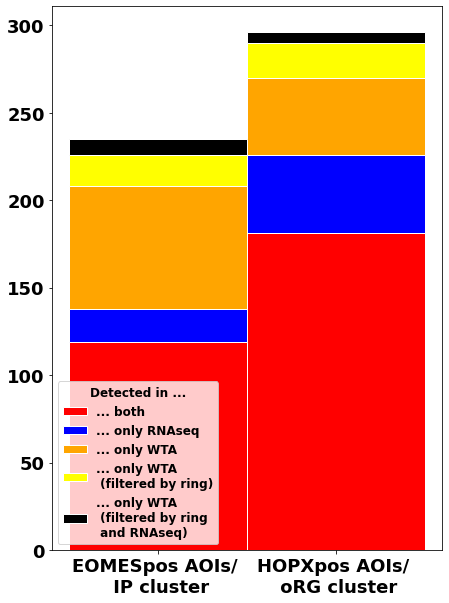

In [20]:
# y-axis in bold
rc('font', weight='bold')
 
# Values of each group
bars1 = [len(overlapIP), len(overlapORG)]
bars2 = [len(uniqueEOMES_genes)-len(uniqueEOMES_genes1)-len(uniqueEOMES_genes2),
         len(uniqueHOPX_genes) - len(uniqueHOPX_genes1) - len(uniqueHOPX_genes2)]
bars3 = [len(uniqueIP), len(uniqueORG)]
bars4 = [len(uniqueEOMES_genes1)-len(uniqueEOMES_genes2), len(uniqueHOPX_genes1)-len(uniqueHOPX_genes2)]
bars5 = [len(uniqueEOMES_genes2), len(uniqueHOPX_genes2)]

# Heights of bars1 + bars2
bars = np.add(bars1, bars3).tolist()
barss = np.add(bars,bars2).tolist()
barsss = np.add(barss,bars4).tolist()

# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['EOMESpos AOIs/ \n IP cluster', 'HOPXpos AOIs/ \n oRG cluster']
barWidth = 1

plt.figure(figsize=(7,10))
# Create brown bars
plt.bar(r, bars1, color= 'red', edgecolor='white', width=barWidth, label = '... both')
# Create green bars (top)
plt.bar(r, bars3, bottom=bars1, color='blue', edgecolor='white', width=barWidth, label = '... only RNAseq')
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars, color='orange', edgecolor='white', width=barWidth, label = '... only WTA')
# Create green bars (top)
plt.bar(r, bars4, bottom=barss, color='yellow', edgecolor='white', width=barWidth, label = '... only WTA \n (filtered by ring)')
# Create green bars (top)
plt.bar(r, bars5, bottom=barsss, color='black', edgecolor='white', width=barWidth, label = '... only WTA \n (filtered by ring \n and RNAseq)')

# Custom X axis
plt.xticks(r, names, fontweight='bold')

plt.legend(title = 'Detected in ...', title_fontsize = 12)

plt.savefig('../KR_NAS/0_publication_figures/Figure4_LigandReceptors_Detected_StackedBarPlot_Draft3.pdf')

# Show graphic
plt.show()

In [21]:
# Save the data as table too:
tab1 = pd.DataFrame(data = [bars1, bars3, bars2, bars4, bars5],
                   index = ('both', 'only RNAseq', 'only WTA', 'only WTA (filter by reference ring)', 'only WTA (filtered by reference rings and RNAseq data)'),
                   columns = ('EOMESpos AOIs/IP cluster', 'HOPXpos AOIs/oRG cluster'))
tab1.to_csv('../KR_NAS/0_publication_tables/ReceptorLigand_Detection_Overlap.csv')

Make plot of top 50 oRG interactions that are also detected in WTA:

In [52]:
cellDB_pvalues = pd.read_table('../data/fetalBrain/Polioudakis/cellPhoneDB/pvalues.txt')

In [53]:
cellDB_pvalues

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,vRG|IP,vRG|InCGE,vRG|InMGE,vRG|Mic,vRG|OPC,vRG|Per,vRG|PgG2M,vRG|PgS,vRG|oRG,vRG|vRG
0,CPI-SS028784FC6,HLA-DPA1_TNFSF9,simple:HLADPA1,simple:P41273,HLA-DPA1,TNFSF9,True,True,False,InnateDB-All,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-SS00A8596B5,PVR_TNFSF9,simple:P15151,simple:P41273,PVR,TNFSF9,True,True,False,InnateDB-All,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,CPI-SS0B84DAE3D,PVR_CD96,simple:P15151,simple:P40200,PVR,CD96,True,True,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,CPI-SS0A8627ED6,PVR_CD226,simple:P15151,simple:Q15762,PVR,CD226,True,True,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,CPI-SS00561BBD7,PVR_TIGIT,simple:P15151,simple:Q495A1,PVR,TIGIT,True,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971,CPI-SC0A68C5F13,IGF1_a6b4 complex,simple:P05019,complex:a6b4 complex,IGF1,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
972,CPI-SC0FDB4B6D9,GDF9_TGFR_BMPR2,simple:O60383,complex:TGFR_BMPR2,GDF9,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
973,CPI-CS0BAF97962,PDGFR complex_PDGFD,complex:PDGFR complex,simple:Q9GZP0,NaN,PDGFD,True,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
974,CPI-CS0C57A3081,PlexinA1_complex1_SEMA6D,complex:PlexinA1_complex1,simple:Q8NFY4,NaN,SEMA6D,False,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
5,CPI-SS0D954EA1C,PDGFRB,PDGFD,True,False,[1],True
7,CPI-SS0D782F60B,WNT4,FZD8,False,True,[1],True
...,...,...,...,...,...,...,...
108,CPI-SS02904BE32,GLRA2,FAM3C,True,False,[1],True
109,CPI-SS090FC28E1,EPHB6,EFNB2,True,True,[1],True
110,CPI-SS0E075E5AF,NRG1,NETO2,True,True,[0],True
112,CPI-SS01A07768A,CD46,JAG1,True,False,[0],True


In [55]:
cellDB_pvalues = cellDB_pvalues.loc[[i in np.array(interact_genes['id_cp_interaction']) for i in cellDB_pvalues['id_cp_interaction']],:]

In [56]:
cellDB_pvalues

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,vRG|IP,vRG|InCGE,vRG|InMGE,vRG|Mic,vRG|OPC,vRG|Per,vRG|PgG2M,vRG|PgS,vRG|oRG,vRG|vRG
17,CPI-SS02D18D12B,CADM3_CADM4,simple:Q8N126,simple:Q8NFZ8,CADM3,CADM4,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
37,CPI-SS0F2C6A4D4,FGF18_FGFR1,simple:O76093,simple:P11362,FGF18,FGFR1,True,False,True,I2D,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
43,CPI-SS0F6A7A4DF,FGF18_FGFR2,simple:O76093,simple:P21802,FGF18,FGFR2,True,False,True,I2D,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
67,CPI-SS034D36D2F,HLA-C_FAM3C,simple:HLAC,simple:Q92520,HLA-C,FAM3C,True,True,False,InnateDB-All,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
69,CPI-SS02904BE32,GLRA2_FAM3C,simple:P23416,simple:Q92520,GLRA2,FAM3C,True,True,False,InnateDB-All,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,CPI-CS067298D94,FLT1 complex_VEGFA,complex:FLT1 complex,simple:P15692,NaN,VEGFA,True,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
947,CPI-CS0D238C22B,PlexinA2_complex1_SEMA3A,complex:PlexinA2_complex1,simple:Q14563,NaN,SEMA3A,True,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
949,CPI-CS0AB19226A,PlexinA4_complex1_SEMA3A,complex:PlexinA4_complex1,simple:Q14563,NaN,SEMA3A,True,True,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
956,CPI-CS0E661878B,LIFR_OSM,complex:LIFR,simple:P13725,NaN,OSM,True,True,False,curated,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [57]:
tab = cellDB_pvalues.loc[:,[any([y == 'oRG' for y in x.split('|')]) for x in cellDB_pvalues.columns]]
tab = np.array(cellDB_pvalues['id_cp_interaction'].loc[np.array([np.min(tab.iloc[i,:]) for i in range(np.shape(tab)[0])]) == 0])

In [72]:
tab1 = cellDB_pvalues.loc[:,[any([y == 'oRG' for y in x.split('|')]) for x in cellDB_pvalues.columns]]
tab1 = np.array(cellDB_pvalues['id_cp_interaction'].loc[np.array([np.min(tab1.iloc[i,:]) for i in range(np.shape(tab1)[0])]) < 0.05])

In [77]:
tab1 = cellDB_pvalues.loc[:,[any([y == 'oRG' for y in x.split('|')]) for x in cellDB_pvalues.columns]]
[np.min(tab1.iloc[i,:]) for i in range(np.shape(tab1)[0])]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [70]:
len(tab)

94

In [58]:
tab

array(['CPI-SS02D18D12B', 'CPI-SS0F2C6A4D4', 'CPI-SS0F6A7A4DF',
       'CPI-SS034D36D2F', 'CPI-SS02904BE32', 'CPI-SS0B02DE712',
       'CPI-SS09375CA29', 'CPI-SS0BF9FA3F2', 'CPI-SS00EDDD458',
       'CPI-SS0ABC5C1B8', 'CPI-SS088A0A760', 'CPI-SS0302E8E8F',
       'CPI-SS0C10824C7', 'CPI-SS03098AC28', 'CPI-SS09808DEAE',
       'CPI-SS0DE0A486F', 'CPI-SS0E00478B4', 'CPI-SS08083B141',
       'CPI-SS07CCAD9BF', 'CPI-SS0F8EFEECF', 'CPI-SS027CDEA08',
       'CPI-SS003C9A532', 'CPI-SS01A07768A', 'CPI-SS02928C71A',
       'CPI-SS0339AE950', 'CPI-SS0472C478C', 'CPI-SS083CBFACD',
       'CPI-SS0CB4F2FE4', 'CPI-SS0D782F60B', 'CPI-SS03E450F99',
       'CPI-SS002673EFE', 'CPI-SS039799099', 'CPI-SS038E93B77',
       'CPI-SS0907A7598', 'CPI-SS087E0E3FB', 'CPI-SS00D9A0644',
       'CPI-SS0CC898553', 'CPI-SS098F416C1', 'CPI-SS060B82BBC',
       'CPI-SS0C03F7CDC', 'CPI-SS059EEFDC6', 'CPI-SS0BD5C2A23',
       'CPI-SS0708FE6FF', 'CPI-SS0E075E5AF', 'CPI-SS090FC28E1',
       'CPI-SS0DC4D593E', 'CPI-SS0470AF8

In [59]:
interact_genes = interact_genes.loc[[i in tab for i in interact_genes['id_cp_interaction']],:]
interact_genes = interact_genes.loc[interact_genes['interaction_detected'],:]

In [60]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
5,CPI-SS0D954EA1C,PDGFRB,PDGFD,True,False,[1],True
7,CPI-SS0D782F60B,WNT4,FZD8,False,True,[1],True
...,...,...,...,...,...,...,...
108,CPI-SS02904BE32,GLRA2,FAM3C,True,False,[1],True
109,CPI-SS090FC28E1,EPHB6,EFNB2,True,True,[1],True
110,CPI-SS0E075E5AF,NRG1,NETO2,True,True,[0],True
112,CPI-SS01A07768A,CD46,JAG1,True,False,[0],True


Plot top receptor expression (geometric mean for multimeric proteins) in HOPXpos AOIs, remove oRG-oRG interactions and interaction that have no genes annotated as receptor and manually annotate those that have both genes annotated as receptors.

In [61]:
interact_genes = interact_genes.loc[[len(i) == 1 for i in interact_genes['oRG_position']],:]

In [62]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
5,CPI-SS0D954EA1C,PDGFRB,PDGFD,True,False,[1],True
7,CPI-SS0D782F60B,WNT4,FZD8,False,True,[1],True
...,...,...,...,...,...,...,...
108,CPI-SS02904BE32,GLRA2,FAM3C,True,False,[1],True
109,CPI-SS090FC28E1,EPHB6,EFNB2,True,True,[1],True
110,CPI-SS0E075E5AF,NRG1,NETO2,True,True,[0],True
112,CPI-SS01A07768A,CD46,JAG1,True,False,[0],True


In [63]:
interact_genes.loc[[np.all(interact_genes.loc[:, ('receptor_a', 'receptor_b')].iloc[i]) for i in range(np.shape(interact_genes)[0])],:]

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
15,CPI-SS00D9A0644,FGFR2,CD83,True,True,[0],True
16,CPI-SS0CC898553,FGFR2,PTPRR,True,True,[0],True
38,CPI-SS09375CA29,ADGRL1,NRG1,True,True,[1],True
41,CPI-SS0C10824C7,EGFR,HBEGF,True,True,[1],True
42,CPI-SS0BF9FA3F2,ERBB3,NRG1,True,True,[1],True
43,CPI-SS0708FE6FF,NRG1,LSR,True,True,[0],True
48,CPI-SS0B02DE712,EGFR,NRG1,True,True,[1],True
53,CPI-SS087E0E3FB,EFNB2,EPHA4,True,True,[0],True
71,CPI-SS03098AC28,ERBB4,HBEGF,True,True,[1],True
76,CPI-SS0339AE950,SIRPA,CD47,True,True,[1],True


In [64]:
interact_genes.loc[[not np.any(interact_genes.loc[:, ('receptor_a', 'receptor_b')].iloc[i]) for i in range(np.shape(interact_genes)[0])],:]

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
12,CPI-SC0CE433AB8,COL4A5,"[ITGB1, ITGA11]",False,False,[0],True
19,CPI-SC0F9DD28F3,JAM3,"[ITGB2, ITGAM]",False,False,[0],True
24,CPI-SC0CA7B34A5,COL5A2,"[ITGB1, ITGA2]",False,False,[1],True
25,CPI-SC00064A9CE,COL20A1,"[ITGB1, ITGA2]",False,False,[1],True
27,CPI-SC054484F7B,COL3A1,"[ITGB1, ITGA2]",False,False,[1],True
28,CPI-SC05CCF815E,COL1A2,"[ITGB1, ITGA2]",False,False,[1],True
29,CPI-SC0FC645961,COL5A3,"[ITGB1, ITGA2]",False,False,[1],True
30,CPI-SC01F1F24AA,COL9A3,"[ITGB1, ITGA2]",False,False,[1],True
31,CPI-SC08226CD3B,COL9A2,"[ITGB1, ITGA2]",False,False,[1],True


In [29]:
oRG_genes = [interact_genes.loc[:, ('gene_a', 'gene_b')].iloc[i,interact_genes['oRG_position'].iloc[i][0]] for i in range(len(interact_genes['oRG_position']))]
matching_genes = [interact_genes.loc[:, ('gene_a', 'gene_b')].iloc[i,[1,0][interact_genes['oRG_position'].iloc[i][0]]] for i in range(len(interact_genes['oRG_position']))]
subset = [interact_genes.loc[:, ('receptor_a', 'receptor_b')].iloc[i,interact_genes['oRG_position'].iloc[i][0]] for i in range(len(interact_genes['oRG_position']))]
oRG_receptors = np.array(oRG_genes)[np.array(subset)]
matching_ligands = np.array(matching_genes)[np.array(subset)]

In [50]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
5,CPI-SS0D954EA1C,PDGFRB,PDGFD,True,False,[1],True
7,CPI-SS0D782F60B,WNT4,FZD8,False,True,[1],True
...,...,...,...,...,...,...,...
108,CPI-SS02904BE32,GLRA2,FAM3C,True,False,[1],True
109,CPI-SS090FC28E1,EPHB6,EFNB2,True,True,[1],True
110,CPI-SS0E075E5AF,NRG1,NETO2,True,True,[0],True
112,CPI-SS01A07768A,CD46,JAG1,True,False,[0],True


In [32]:
interact_genes

,id_cp_interaction,gene_a,gene_b,receptor_a,receptor_b,oRG_position,interaction_detected
0,CPI-SC0BC542ACC,TNC,"[ITGB1, ITGA4]",False,False,[0],True
1,CPI-SS0F8EFEECF,TNF,DAG1,False,True,[1],True
4,CPI-SS03CC15FF3,PDGFRA,PDGFC,True,False,[1],True
5,CPI-SS0D954EA1C,PDGFRB,PDGFD,True,False,[1],True
7,CPI-SS0D782F60B,WNT4,FZD8,False,True,[1],True
...,...,...,...,...,...,...,...
108,CPI-SS02904BE32,GLRA2,FAM3C,True,False,[1],True
109,CPI-SS090FC28E1,EPHB6,EFNB2,True,True,[1],True
110,CPI-SS0E075E5AF,NRG1,NETO2,True,True,[0],True
112,CPI-SS01A07768A,CD46,JAG1,True,False,[0],True


In [33]:
matching_ligands

array(['TNF', 'WNT4', 'DLL4', 'FGF18', 'EFNA5', 'CD83', 'PTPRR', 'PDGFB',
       'ADGRL1', 'EGFR', 'ERBB3', 'LSR', 'EGFR', 'PDGFB', 'FGF18',
       'EPHA4', 'DLL3', 'JAG1', 'FGF9', 'OSM', 'ERBB4', 'SIRPA', 'EFNA1',
       'ERBB4', 'WNT5A', 'XPR1', 'FGF9', 'GRN', 'EPHB1', 'NCAM1', 'EPHB6',
       'NETO2', 'JAG1'], dtype=object)

In [34]:
input_data = pickle.load(open( "../KR_NAS/data/ROI_relations.p", "rb" ))
input_data = input_data.loc[input_data['Slide'] != '00MW']
input_data

,Slide,Radial_position,VCDepth,Background,HOPXpos,EOMESpos,ParallelROI,Ring
0,00MU,1,0.028892,126,111,103,107,118
1,00MU,1,0.094703,156,141,134,122,148
2,00MU,1,0.205457,96,172,164,137,180
3,00MU,1,0.303371,127,112,104,152,119
4,00MU,1,0.382022,157,142,135,160,149
5,00MU,3,0.028892,94,170,162,107,178
6,00MU,3,0.094703,125,110,102,122,117
7,00MU,3,0.205457,155,140,133,137,147
8,00MU,3,0.303371,95,171,163,152,179
9,00MU,3,0.382022,97,173,165,160,181


In [35]:
input_data = input_data.loc[input_data['Slide'] == '00MU']
input_data

,Slide,Radial_position,VCDepth,Background,HOPXpos,EOMESpos,ParallelROI,Ring
0,00MU,1,0.028892,126,111,103,107,118
1,00MU,1,0.094703,156,141,134,122,148
2,00MU,1,0.205457,96,172,164,137,180
3,00MU,1,0.303371,127,112,104,152,119
4,00MU,1,0.382022,157,142,135,160,149
5,00MU,3,0.028892,94,170,162,107,178
6,00MU,3,0.094703,125,110,102,122,117
7,00MU,3,0.205457,155,140,133,137,147
8,00MU,3,0.303371,95,171,163,152,179
9,00MU,3,0.382022,97,173,165,160,181


In [36]:
x_coordinate = input_data.loc[:,'VCDepth']
adata_background = adata[list(input_data['Background']),:]
adata_AOIs = list((adata[list(input_data['HOPXpos']),:], adata[list(input_data['EOMESpos']),:]))

In [37]:
oRG_receptors = oRG_genes
matching_ligands = matching_genes

oRG_receptors_joint = [i if not isinstance(i, list) else '-'.join(i) for i in oRG_receptors]
matching_ligands_joint = [i if not isinstance(i, list) else '-'.join(i) for i in matching_ligands]

newOrder = np.argsort(np.array(oRG_receptors_joint))
oRG_receptors_joint = np.array(oRG_receptors_joint)[newOrder]
matching_ligands_joint = np.array(matching_ligands_joint)[newOrder]
oRG_receptors = np.array(oRG_receptors)[newOrder]
matching_ligands = np.array(matching_ligands)[newOrder]

In [38]:
matching_ligands = np.flipud(matching_ligands)
oRG_receptors = np.flipud(oRG_receptors)
matching_ligands_joint = np.flipud(matching_ligands_joint)
oRG_receptors_joint = np.flipud(oRG_receptors_joint)

/nfs/team283/aa16/software/miniconda3/envs/cellpymc/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


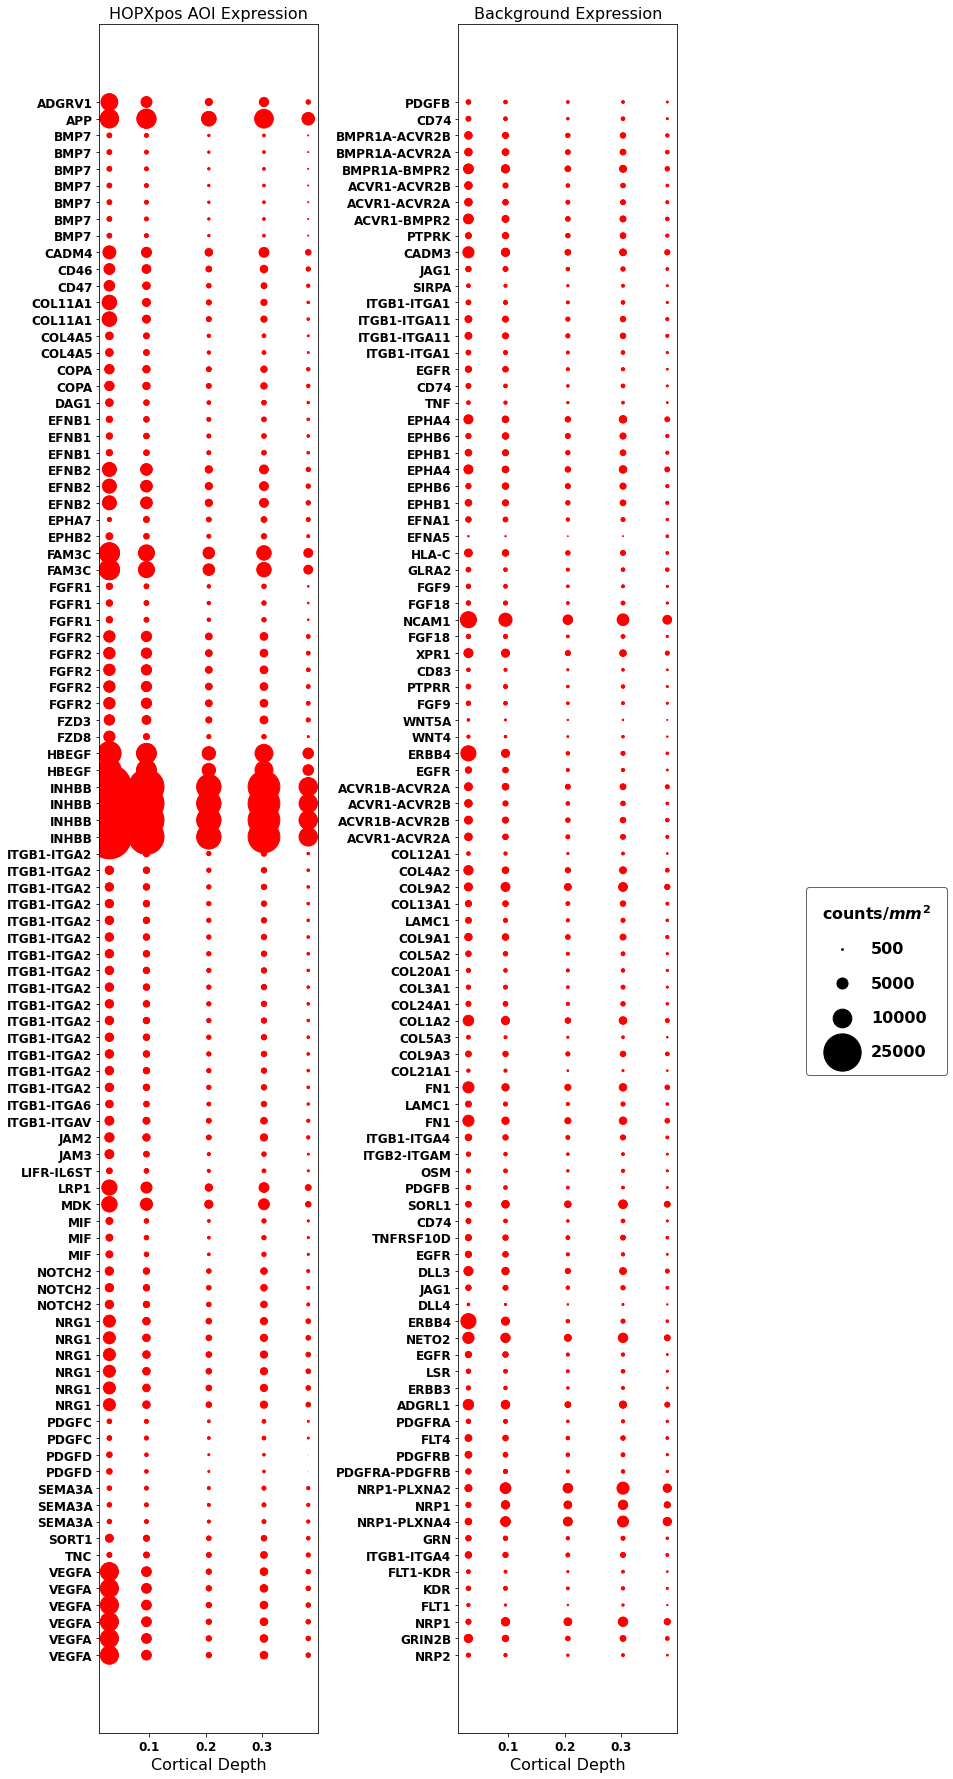

In [39]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 0.005
power = 1.5

def geo_mean(x):
    y = [x[:,i].prod()**(1.0/len(x[:,i])) for i in range(len(x[0,:]))]
    return(y)

fig, ax = plt.subplots(1,2,figsize = (12, 25), sharex = True)

# HOPXpos AOIs:
target_index = 0
nontarget_index = (1,0)[target_index]
normCounts_AOI = np.array([adata_AOIs[target_index].layers['X'][i,:]/
                                                   adata_AOIs[target_index].obs['roi_dimension'].iloc[:,0].iloc[i]
                                for i in range(np.shape(adata_AOIs[target_index].layers['X'])[0])])*10**6

normCounts_Background = np.array([(adata_background.layers['X'][i,:] + adata_AOIs[nontarget_index].layers['X'][i,:])/
                         (adata_background.obs['roi_dimension'].iloc[:,0].iloc[i] + 
                          adata_AOIs[nontarget_index].obs['roi_dimension'].iloc[:,0].iloc[i])
                                for i in range(np.shape(adata_background.layers['X'])[0])])*10**6


# Receptors:

genesForPlot = np.repeat(range(len(oRG_receptors_joint)),np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(oRG_receptors))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]]
          if not isinstance(j, list)
          else geo_mean(np.array([normCounts_Background[:,np.where(adata_background.var_names == k)[0][0]] for k in j]))
          for j in oRG_receptors])
ax[0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0].set_title('HOPXpos AOI Expression')
ax[0].set_facecolor('w')
ax[0].set_xlabel('Cortical Depth')
ax[0].set_yticks(np.arange(len(oRG_receptors_joint)))
ax[0].set_yticklabels(oRG_receptors_joint)

# Ligands:
genesForPlot = np.repeat(range(len(matching_ligands_joint)), np.shape(normCounts_AOI)[0])
vcForPlot = np.array([adata_background.obs['VCDepth'] for j in range(len(matching_ligands))]).flatten()
countsForPlot = np.array([normCounts_Background[:,np.where(adata_background.var_names == j)[0][0]]
          if not isinstance(j, list)
          else geo_mean(np.array([normCounts_Background[:,np.where(adata_background.var_names == k)[0][0]] for k in j]))
          for j in matching_ligands])

ax[1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[1].set_title('Background Expression')
ax[1].set_facecolor('w')
ax[1].set_xlabel('Cortical Depth')
ax[1].set_yticks(np.arange(len(matching_ligands_joint)))
ax[1].set_yticklabels(matching_ligands_joint)

# Make a legend:
pws = [0,500,5000,10000,25000]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="counts/$mm^2$", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/MostSpecificORG_Interactions_areaNormalized_counts.pdf',
            bbox_inches='tight')

Also make a heatmap and dotplot of this in scRNAseq data:

In [40]:
meanExpression_sc = pd.read_csv(path + "data/polioudakis2019_meanExpressionProfiles.csv", index_col=0)

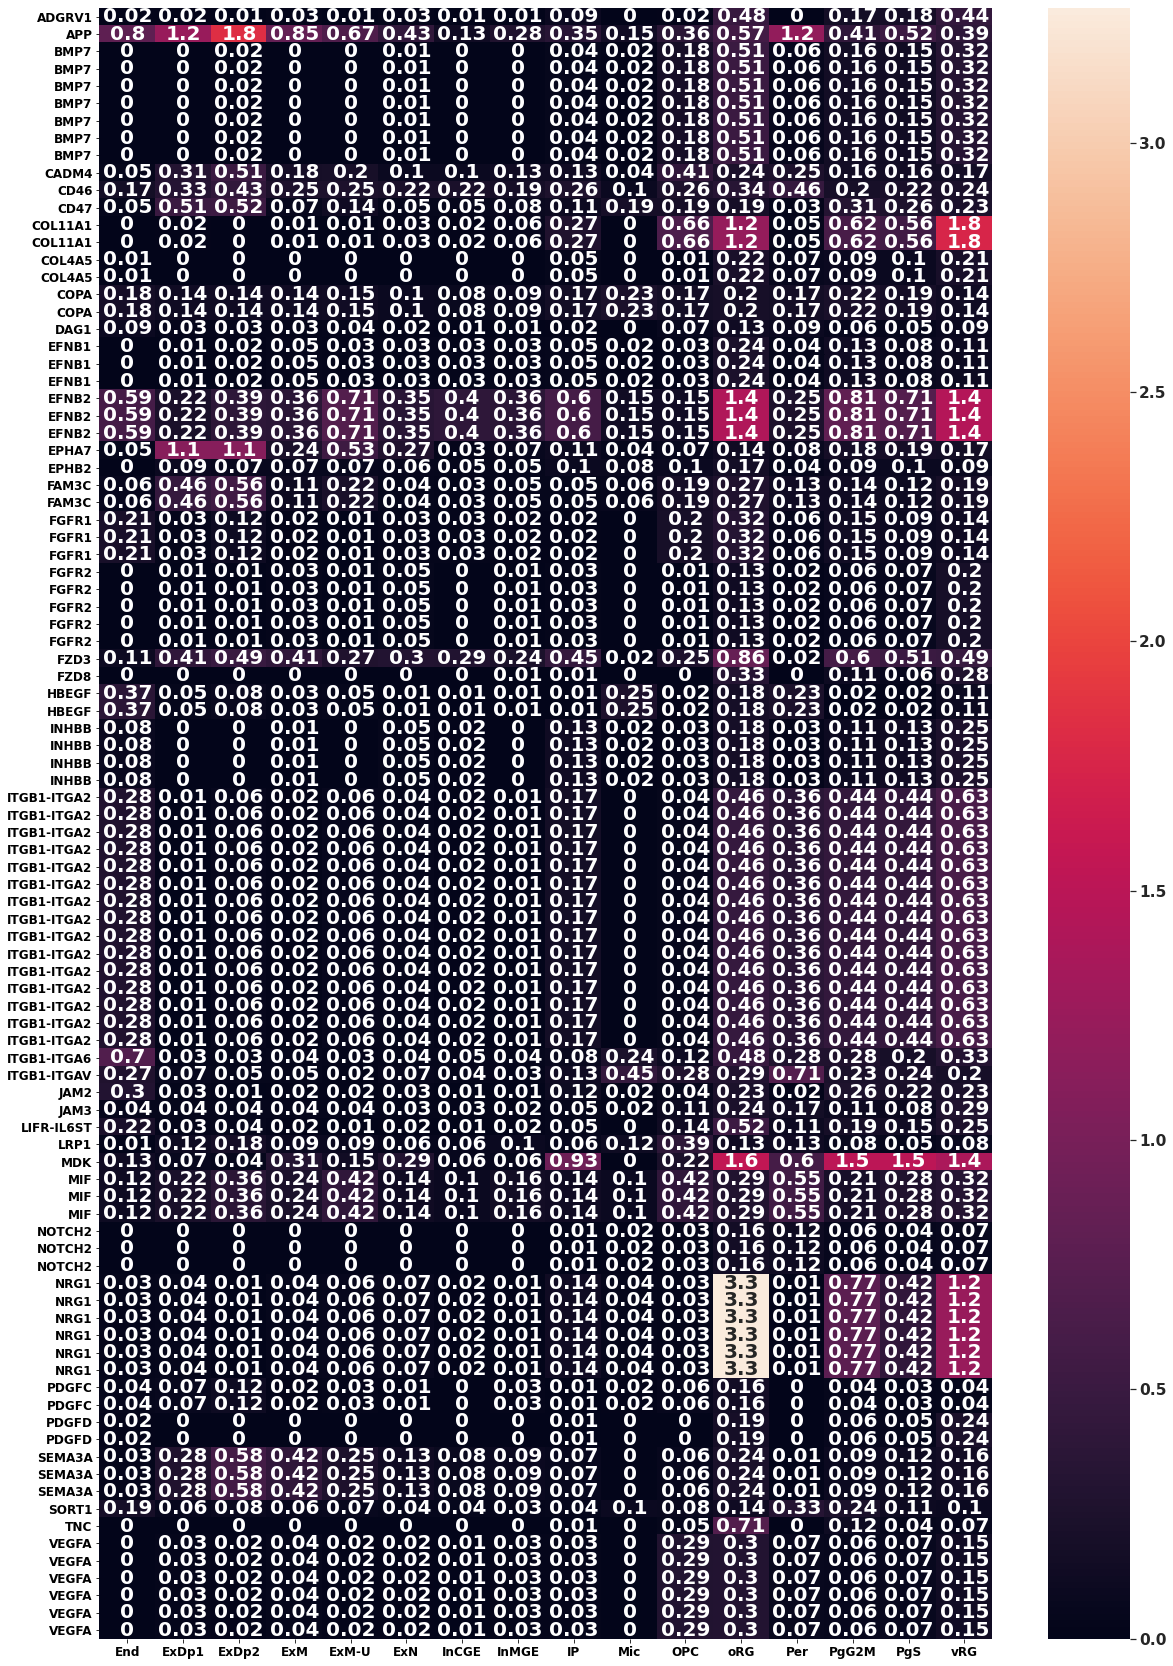

In [41]:
countsForPlot = np.array([meanExpression_sc.loc[j,:]
          if not isinstance(j, list)
          else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
          for j in np.flipud(oRG_receptors)])
countsForPlot = pd.DataFrame(data = countsForPlot, index = np.flipud(oRG_receptors_joint), columns = meanExpression_sc.columns)

fig, ax = plt.subplots(figsize=(20,30))
sns.set(font_scale=1.4)
sns.heatmap(np.round(countsForPlot,2), annot = True,  annot_kws={"size": 20})
plt.savefig('../KR_NAS/0_publication_figures/MostSpecificORG_Interactions_oRG-Receptors_SC-counts.pdf',
            bbox_inches='tight')

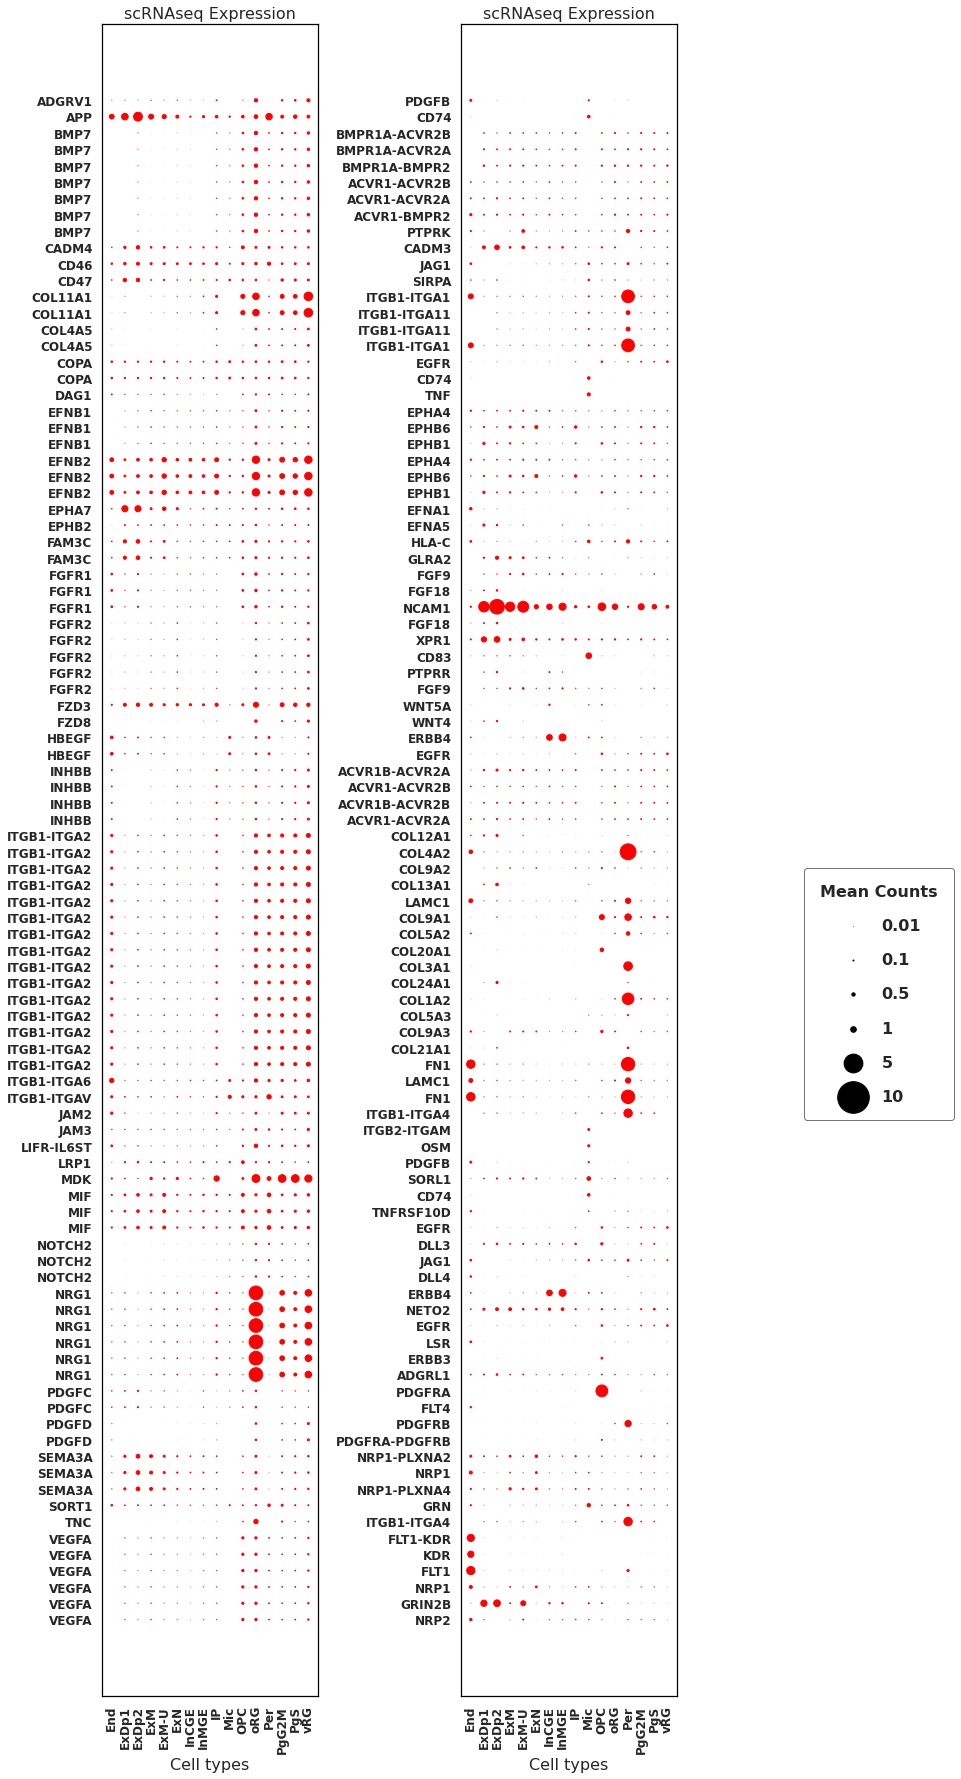

In [42]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 10
power = 1.5

def geo_mean(x):
    y = [x[:,i].prod()**(1.0/len(x[:,i])) for i in range(len(x[0,:]))]
    return(y)

fig, ax = plt.subplots(1,2,figsize = (12, 25), sharex = True)

# Receptors:
countsForPlot = np.array([meanExpression_sc.loc[j,:]
          if not isinstance(j, list)
          else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
          for j in oRG_receptors])

genesForPlot = np.repeat(list(range(len(oRG_receptors_joint))),np.shape(countsForPlot)[1])
vcForPlot = np.array([meanExpression_sc.columns for j in range(len(oRG_receptors))]).flatten()
ax[0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0].set_title('scRNAseq Expression')
ax[0].set_facecolor('w')
ax[0].set_xlabel('Cell types')
ax[0].set_yticklabels(oRG_receptors_joint)
ax[0].tick_params('x', labelrotation=90)
ax[0].set_yticks(np.arange(len(oRG_receptors_joint)))

# Ligands:
countsForPlot = np.array([meanExpression_sc.loc[j,:]
          if not isinstance(j, list)
          else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
          for j in matching_ligands])

genesForPlot = np.repeat(range(len(matching_ligands_joint)), np.shape(countsForPlot)[1])
vcForPlot = np.array([meanExpression_sc.columns for j in range(len(matching_ligands))]).flatten()

ax[1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[1].set_title('scRNAseq Expression')
ax[1].set_facecolor('w')
ax[1].set_xlabel('Cell types')
ax[1].set_yticklabels(matching_ligands_joint)
ax[1].set_yticks(np.arange(len(matching_ligands_joint)))
plt.xticks(rotation = 90)

# Make a legend:
pws = [0,0.01,0.1,0.5,1,5,10]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="Mean Counts", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.55, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/MostSpecificORG_Interactions_oRG-Receptors_SC-counts-DotPlot_RawCounts.pdf',
            bbox_inches='tight')

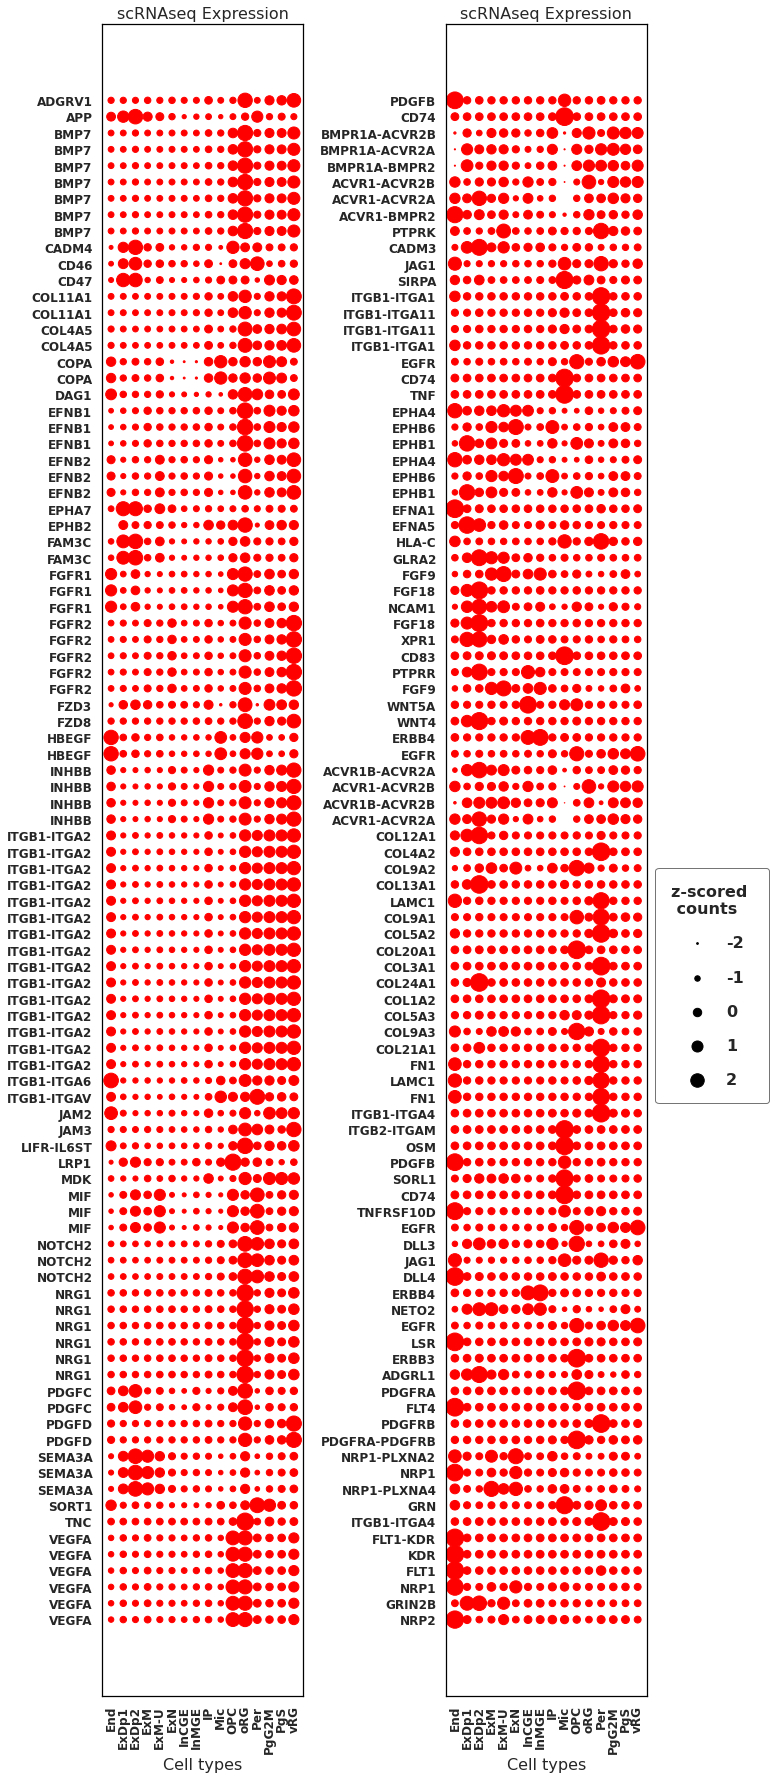

In [43]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.edgecolor"] = "black"

scaling = 7.5
power = 1.5

def geo_mean(x):
    y = [x[:,i].prod()**(1.0/len(x[:,i])) for i in range(len(x[0,:]))]
    return(y)

fig, ax = plt.subplots(1,2,figsize = (12, 25), sharex = True)

# Receptors:
countsForPlot = np.array([meanExpression_sc.loc[j,:]
          if not isinstance(j, list)
          else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
          for j in oRG_receptors])

countsForPlot = sc.stats.zscore(countsForPlot, axis = 1)

genesForPlot = np.repeat(list(range(len(oRG_receptors_joint))),np.shape(countsForPlot)[1])
vcForPlot = np.array([meanExpression_sc.columns for j in range(len(oRG_receptors))]).flatten()
ax[0].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[0].set_title('scRNAseq Expression')
ax[0].set_facecolor('w')
ax[0].set_xlabel('Cell types')
ax[0].set_yticklabels(oRG_receptors_joint)
ax[0].tick_params('x', labelrotation=90)
ax[0].set_yticks(np.arange(len(oRG_receptors_joint)))

# Ligands:
countsForPlot = np.array([meanExpression_sc.loc[j,:]
          if not isinstance(j, list)
          else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
          for j in matching_ligands])

countsForPlot = sc.stats.zscore(countsForPlot, axis = 1)

genesForPlot = np.repeat(range(len(matching_ligands_joint)), np.shape(countsForPlot)[1])
vcForPlot = np.array([meanExpression_sc.columns for j in range(len(matching_ligands))]).flatten()

ax[1].scatter(vcForPlot, genesForPlot, s=((-np.amin(countsForPlot*scaling) + countsForPlot*scaling))**power,
            c= 'red')
ax[1].set_title('scRNAseq Expression')
ax[1].set_facecolor('w')
ax[1].set_xlabel('Cell types')
ax[1].set_yticklabels(matching_ligands_joint)
ax[1].set_yticks(np.arange(len(matching_ligands_joint)))
plt.xticks(rotation = 90)

# Make a legend:
pws = [0,-2,-1,0,1,2]
for pw in pws:
    plt.scatter([], [], s=((-np.amin(countsForPlot*scaling) + pw*scaling))**power, c="black",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
lgd = plt.legend(h[1:], l[1:], labelspacing=1.2, title="z-scored \n counts", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", bbox_to_anchor=(1.65, 0.5))

plt.tight_layout()

plt.savefig('../KR_NAS/0_publication_figures/MostSpecificORG_Interactions_oRG-Receptors_SC-counts-DotPlot_Z-scored.pdf',
            bbox_inches='tight')

In [44]:
# countsForPlot = np.array([meanExpression_sc.loc[j,:]
#           if not isinstance(j, list)
#           else geo_mean(np.array([meanExpression_sc.loc[k,:] for k in j]))
#           for j in np.flipud(matching_ligands)])
# countsForPlot = pd.DataFrame(data = countsForPlot, index = np.flipud(matching_ligands_joint), columns = meanExpression_sc.columns)

# fig, ax = plt.subplots(figsize=(20,30))
# sns.set(font_scale=1.4)
# sns.heatmap(np.round(countsForPlot,2), annot = True,  annot_kws={"size": 20})
# plt.savefig('../KR_NAS/0_publication_figures/MostSpecificORG_Interactions_MatchingLigands_SC-counts.pdf',
#             bbox_inches='tight')